In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediccion-precios-laptops/sample_submission.csv
/kaggle/input/prediccion-precios-laptops/train.csv
/kaggle/input/prediccion-precios-laptops/test.csv


In [164]:
train = pd.read_csv('/kaggle/input/prediccion-precios-laptops/train.csv')
test = pd.read_csv('/kaggle/input/prediccion-precios-laptops/test.csv')

In [165]:
test['Price_euros'] = -1
X = pd.concat([train, test], axis=0)
X.reset_index(drop=True,inplace=True)

In [166]:
print(train.shape,test.shape)

(912, 14) (391, 14)


In [167]:
train.head(2)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,697,705,Asus,Chromebook Flip,2 in 1 Convertible,12.5,Full HD / Touchscreen 1920x1080,Intel Core M M3-6Y30 0.9GHz,4GB,64GB Flash Storage,Intel HD Graphics 515,Chrome OS,1.2kg,669.0
1,435,442,Asus,Rog Strix,Gaming,17.3,Full HD 1920x1080,AMD Ryzen 1600 3.2GHz,8GB,256GB SSD + 1TB HDD,AMD Radeon RX 580,Windows 10,3.2kg,1695.0


In [168]:
# revisar valores nulos
train.isnull().sum()

id                  0
laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [169]:
# Resumen estadístico de las variables
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,912.0,652.099781,375.428905,0.0,332.5,655.5,980.5,1301.0
laptop_ID,912.0,661.273026,380.297415,1.0,338.5,663.5,994.5,1319.0
Inches,912.0,15.060746,1.412363,10.1,14.0,15.6,15.6,18.4
Price_euros,912.0,1126.920340,696.088870,174.0,589.0,952.0,1499.0,4899.0


In [170]:
#descripcion data categórica
pd.set_option('display.max_columns', None)
train.describe(include=['object'])

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
count,912,912,912,912,912,912,912,912,912,912
unique,19,475,6,37,102,9,36,94,9,164
top,Dell,Inspiron 3567,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.2kg
freq,218,24,516,362,143,428,284,191,745,86


In [171]:
train.head(1)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,697,705,Asus,Chromebook Flip,2 in 1 Convertible,12.5,Full HD / Touchscreen 1920x1080,Intel Core M M3-6Y30 0.9GHz,4GB,64GB Flash Storage,Intel HD Graphics 515,Chrome OS,1.2kg,669.0


In [172]:
import re

def F_ScreenResolution(df):
    # Extraer resolucion en pixeles de ScreenResolution (ancho y alto)
    pattern = r"\d{3,4}x\d{3,4}"
    resolutions = []
    for row in range(len(df)):
        match = re.search(pattern, df['ScreenResolution'][row])
        if match:
            resolutions.append(match.group(0))
    ancho = []
    alto = []
    for res in resolutions:
        if 'x' in res:
            ancho.append(int(res[0:4])) # siempre asume que es 4 de ancho
            alto.append(int(res[5:]))
    
    # Obtener si es Touchscreen o IPS Panel
    touchscreen = []
    ips = []
    for row in range(len(df)):
        text = df['ScreenResolution'][row].lower()
        if 'touchscreen' in text:
            touchscreen.append(1)
        else:
            touchscreen.append(0)
        if 'ips panel' in text:
            ips.append(1)
        else:
            ips.append(0)
            
    df['WidthRes'] = ancho
    df['HeightRes'] = alto
    df['Touchscreen'] = touchscreen
    df['IPS_Panel'] = ips
    
    return

In [173]:
def F_Numerical(df):
    # Ram and Weigth
    for row in range(len(df)):
        if 'GB' in df['Ram'][row]:
            df['Ram'][row] = int(df['Ram'][row].replace("GB",""))
        if 'kg' in df['Weight'][row]:
            df['Weight'][row] = float(df['Weight'][row].replace("kg",""))
    return

In [174]:
# clock speed, brand, type processor ordinal
def F_Cpu(df):
    clock_speed = []
    cpu_brand = []
    for row in range(len(df)):
        processor = df['Cpu'][row]
        cs = re.search(r'\d+(\.\d+)?GHz',processor)
        clock_speed.append(float(cs.group().replace('GHz','')))
        #print(processor)
        match = re.search(r'Intel|AMD', processor)
        if match:
            cpu_brand.append(match.group())
        else:
            cpu_brand.append("Other")
    intel = []
    amd = []
    other = []
    for brand in cpu_brand:
        if brand == 'Intel':
            intel.append(1)
            amd.append(0)
            other.append(0)
        elif brand == 'AMD':
            intel.append(0)
            amd.append(1)
            other.append(0)
        else:
            intel.append(0)
            amd.append(0)
            other.append(1)
    df['Cpu_AMD'] = amd
    df['Cpu_Intel'] = intel
    df['Cpu_Other'] = other
    df['Cpu_ClockSpeed'] = clock_speed
    
    processors = df['Cpu']

    df_len = len(df)
    intel_cores = [0] * df_len
    AMD_processors = [0] * df_len
    for i,processor in enumerate(processors):
        if 'Intel' in processor:
            match = re.search(r'Core (i[357])',processor)
            if match:
                intel_cores[i] = int(match.group().replace("Core ","").replace('i',''))
        elif 'AMD' in processor:
            match = re.search(r'A[\d]',processor)
            if match:
                AMD_processors[i] = int(match.group().replace("A",""))
            elif "Ryzen" in processor:
                AMD_processors[i] = 20
    df['Cpu_Intel_Type'] = intel_cores
    df['Cpu_AMD_Type'] = AMD_processors
    
    cpus = df['Cpu']
    generations = [0]*len(df)
    for i,cpu in enumerate(cpus):
        if 'Intel' in cpu:
            if 'Core i' in cpu:
                match = re.search(r'\d{4}\D{2}',cpu)
                if match:
                    generations[i] = int(match.group()[1])
    df['intel_cpu_generation'] = generations
    return

In [175]:
# Return SSD_Storage, HDDStorage
def formatGB(storage):
    if 'TB' in storage:
        return float(storage.replace("TB","")) * 1024
    if 'GB' in storage:
        return float(storage.replace("GB",""))


In [176]:
def F_Memory(df):
    # Memoria en GB, SSD, HDD, Flash
    pattern = "(\d+\.?\d*[TG]B)\s+(SSD|HDD|Flash Storage|Hybrid)"
    fmemories = []
    for m in range(len(df['Memory'])):
         fmemories.append(re.findall(pattern,df['Memory'][m]))
    len_df = len(fmemories)
    hdd = [0] * len_df
    ssd = [0] * len_df
    hybrid = [0] * len_df
    flash = [0] * len_df

    for i,item in enumerate(fmemories):
        for capacity, storage_type in item:
            if storage_type == 'Flash Storage':
                flash[i] = formatGB(capacity)
            elif storage_type == 'SSD':
                ssd[i] = formatGB(capacity)
            elif storage_type == 'HDD':
                hdd[i] = formatGB(capacity)
            elif storage_type == 'Hybrid':
                hybrid[i] = formatGB(capacity)
    df['HDD_Storage'] = hdd
    df['SSD_Storage'] = ssd
    df['Hybrid_Storage'] = hybrid
    df['HDD_Storage'] = flash
    return

In [177]:
F_ScreenResolution(X)
F_Cpu(X)
F_Numerical(X)
F_Memory(X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [178]:
X.head(1)

,id,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,WidthRes,HeightRes,Touchscreen,IPS_Panel,Cpu_AMD,Cpu_Intel,Cpu_Other,Cpu_ClockSpeed,Cpu_Intel_Type,Cpu_AMD_Type,intel_cpu_generation,HDD_Storage,SSD_Storage,Hybrid_Storage
0,697,705,Asus,Chromebook Flip,2 in 1 Convertible,12.5,Full HD / Touchscreen 1920x1080,Intel Core M M3-6Y30 0.9GHz,4,64GB Flash Storage,Intel HD Graphics 515,Chrome OS,1.2,669.0,1920,1080,1,0,0,1,0,0.9,0,0,0,64.0,0.0,0.0


In [179]:
X = X.drop(['Cpu','Cpu_Other','ScreenResolution','laptop_ID','Memory'],axis = 1) 
X.head(2)

,id,Company,Product,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,WidthRes,HeightRes,Touchscreen,IPS_Panel,Cpu_AMD,Cpu_Intel,Cpu_ClockSpeed,Cpu_Intel_Type,Cpu_AMD_Type,intel_cpu_generation,HDD_Storage,SSD_Storage,Hybrid_Storage
0,697,Asus,Chromebook Flip,2 in 1 Convertible,12.5,4,Intel HD Graphics 515,Chrome OS,1.2,669.0,1920,1080,1,0,0,1,0.9,0,0,0,64.0,0.0,0.0
1,435,Asus,Rog Strix,Gaming,17.3,8,AMD Radeon RX 580,Windows 10,3.2,1695.0,1920,1080,0,0,1,0,3.2,0,20,0,0.0,256.0,0.0


In [180]:
# GPU
def F_Gpu(df):
    gpu_brand = []
    for row in range(len(df)):
        brands = re.findall(r'(Intel|AMD|Nvidia)', df['Gpu'][row])
        if len(brands) > 0:
            gpu_brand.append(brands[0])
        else:
            gpu_brand.append('Other')
    df['Gpu_brand'] = gpu_brand
    return df

In [181]:
X = F_Gpu(X)

In [182]:
X = X.drop(['Gpu','Product'],axis = 1)

In [183]:
X.head(1)

,id,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,WidthRes,HeightRes,Touchscreen,IPS_Panel,Cpu_AMD,Cpu_Intel,Cpu_ClockSpeed,Cpu_Intel_Type,Cpu_AMD_Type,intel_cpu_generation,HDD_Storage,SSD_Storage,Hybrid_Storage,Gpu_brand
0,697,Asus,2 in 1 Convertible,12.5,4,Chrome OS,1.2,669.0,1920,1080,1,0,0,1,0.9,0,0,0,64.0,0.0,0.0,Intel


In [184]:
def F_dummies(df):
    # Company, TypeName, OpSys, Gpu_brand
    dummies = pd.get_dummies(df['Company'])
    df = pd.concat([df,dummies],axis=1)
    df = df.drop('Company',axis=1)

    dummies = pd.get_dummies(df['TypeName'],prefix='type')
    df = pd.concat([df,dummies],axis=1)
    df = df.drop('TypeName',axis=1)
    
    dummies = pd.get_dummies(df['OpSys'],prefix='OS')
    df = pd.concat([df,dummies],axis=1)
    df = df.drop('OpSys',axis=1)
    
    dummies = pd.get_dummies(df['Gpu_brand'],prefix='Gpu')
    df = pd.concat([df,dummies],axis=1)
    df = df.drop('Gpu_brand',axis=1)
    return df

In [185]:
X = F_dummies(X)

In [186]:
X.head(1)

,id,Inches,Ram,Weight,Price_euros,WidthRes,HeightRes,Touchscreen,IPS_Panel,Cpu_AMD,Cpu_Intel,Cpu_ClockSpeed,Cpu_Intel_Type,Cpu_AMD_Type,intel_cpu_generation,HDD_Storage,SSD_Storage,Hybrid_Storage,Acer,Apple,Asus,Chuwi,Dell,Fujitsu,Google,HP,Huawei,LG,Lenovo,MSI,Mediacom,Microsoft,Razer,Samsung,Toshiba,Vero,Xiaomi,type_2 in 1 Convertible,type_Gaming,type_Netbook,type_Notebook,type_Ultrabook,type_Workstation,OS_Android,OS_Chrome OS,OS_Linux,OS_Mac OS X,OS_No OS,OS_Windows 10,OS_Windows 10 S,OS_Windows 7,OS_macOS,Gpu_AMD,Gpu_Intel,Gpu_Nvidia,Gpu_Other
0,697,12.5,4,1.2,669.0,1920,1080,1,0,0,1,0.9,0,0,0,64.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [187]:
X['Ram'] = X['Ram'].astype(float)
X['Weight'] = X['Weight'].astype(float)
X['Total_Storage'] = X['HDD_Storage'] + X['SSD_Storage'] + X['Hybrid_Storage']

In [188]:
print(X.dtypes)

id                           int64
Inches                     float64
Ram                        float64
Weight                     float64
Price_euros                float64
WidthRes                     int64
HeightRes                    int64
Touchscreen                  int64
IPS_Panel                    int64
Cpu_AMD                      int64
Cpu_Intel                    int64
Cpu_ClockSpeed             float64
Cpu_Intel_Type               int64
Cpu_AMD_Type                 int64
intel_cpu_generation         int64
HDD_Storage                float64
SSD_Storage                float64
Hybrid_Storage             float64
Acer                         uint8
Apple                        uint8
Asus                         uint8
Chuwi                        uint8
Dell                         uint8
Fujitsu                      uint8
Google                       uint8
HP                           uint8
Huawei                       uint8
LG                           uint8
Lenovo              

# Entrenamiento de modelos

In [189]:
X2 = X[X['Price_euros']>-1]
test = X[X['Price_euros']==-1]

In [190]:
test = test.drop('Price_euros',axis=1)
test_id = test['id']
test = test.drop('id',axis=1)

In [191]:
Y2 = X2['Price_euros']
X2 = X2.drop('Price_euros',axis=1)
X2_id = X2['id']
X2 = X2.drop('id',axis=1)

In [193]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

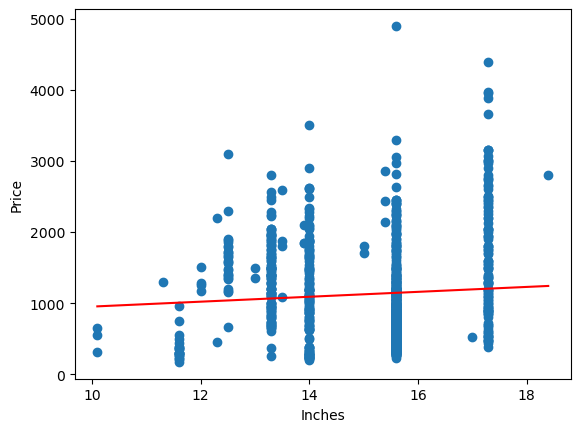

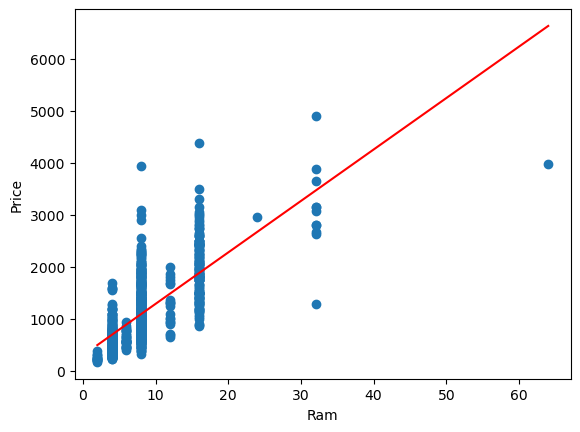

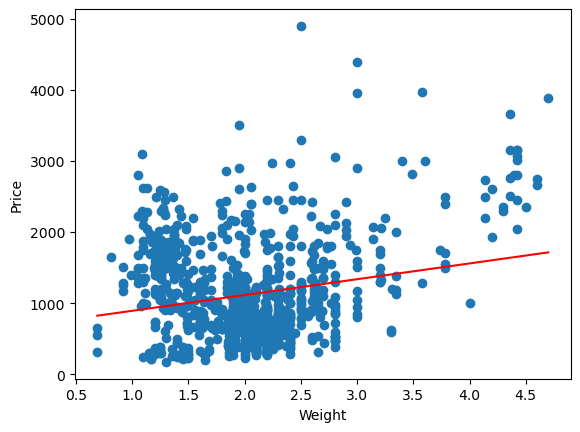

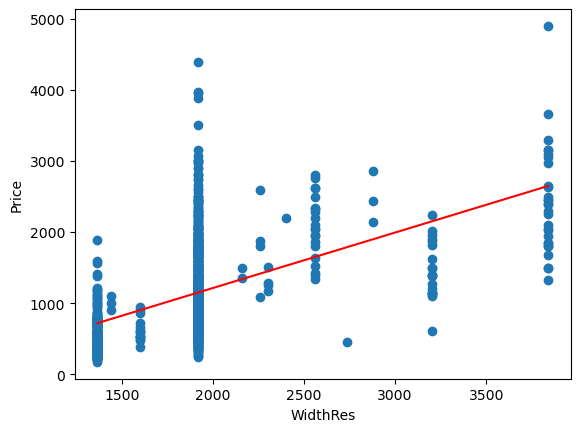

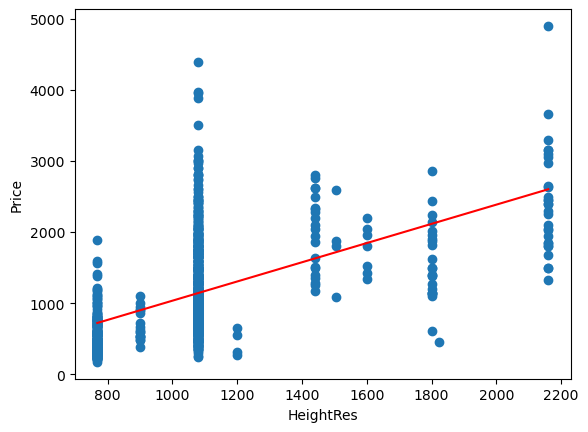

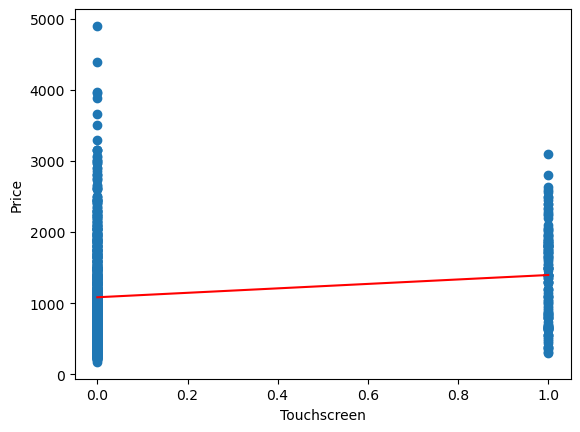

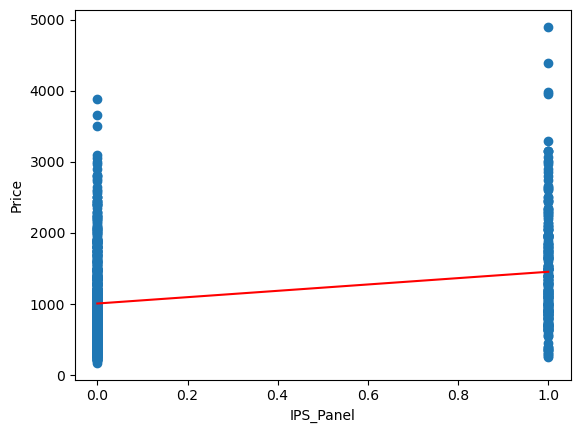

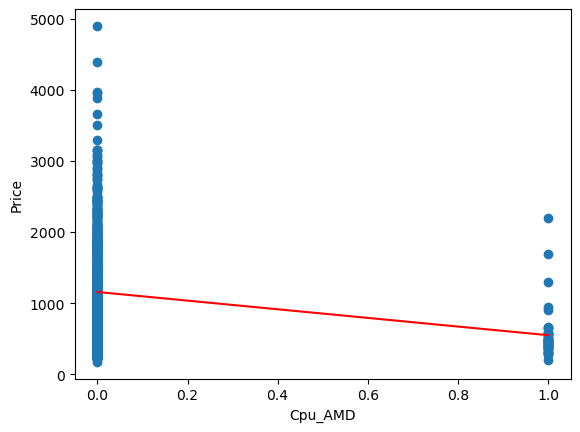

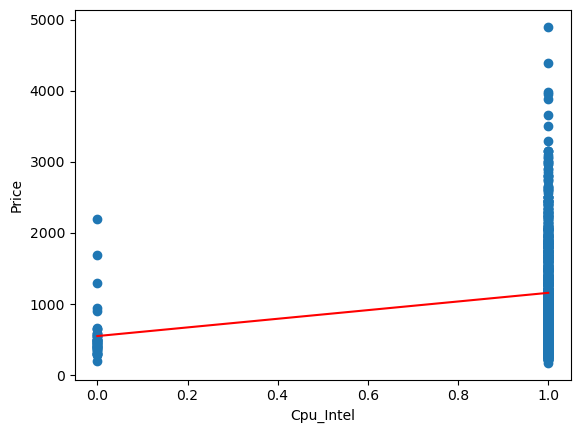

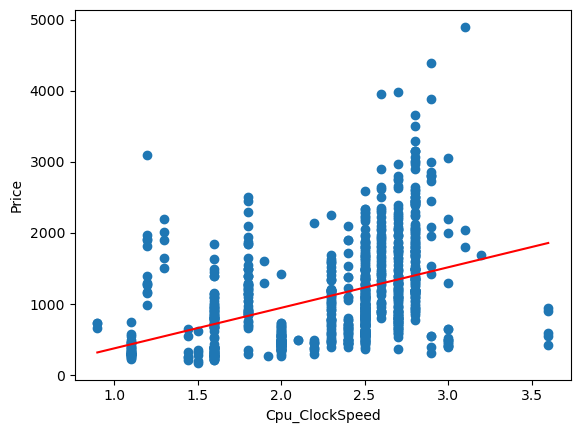

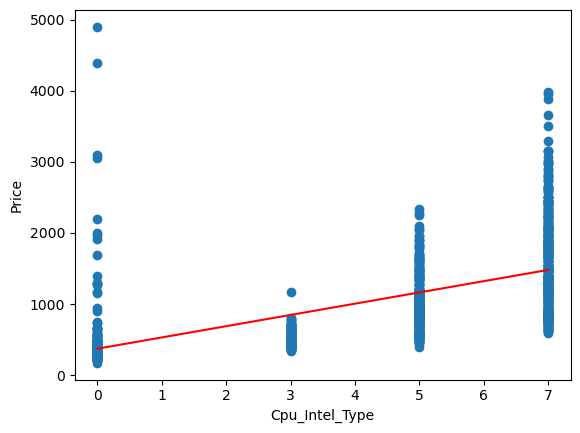

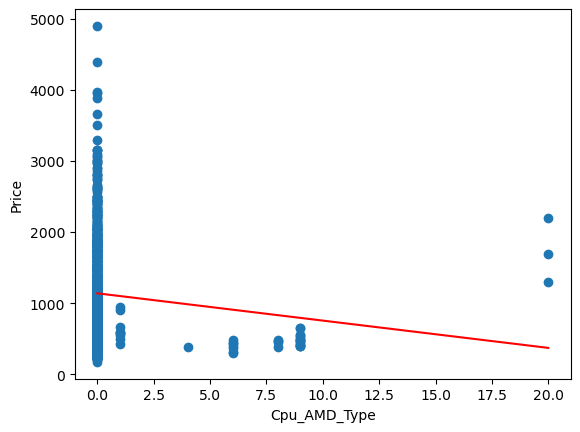

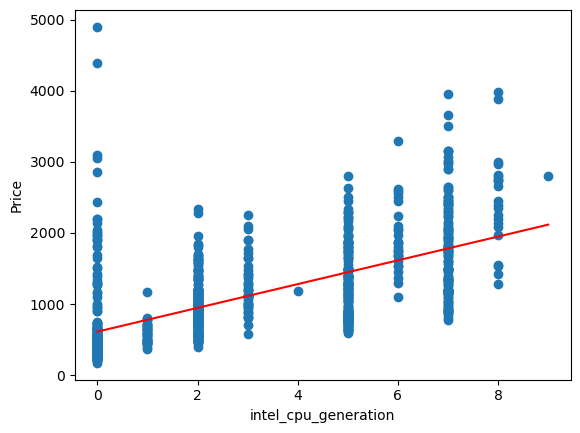

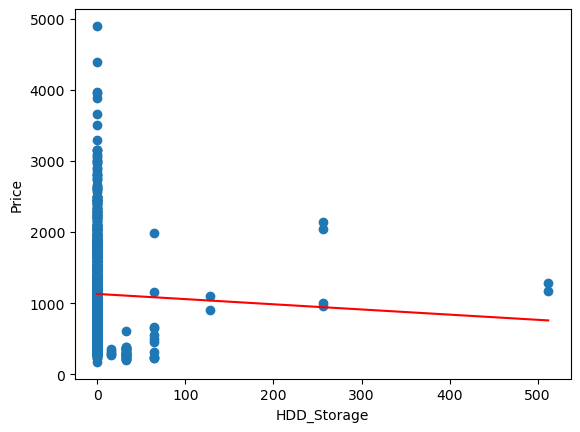

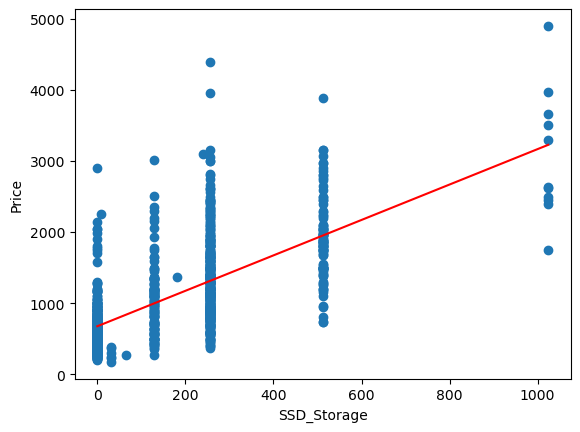

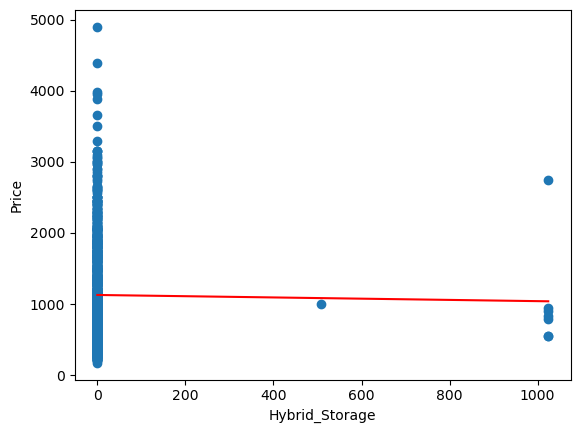

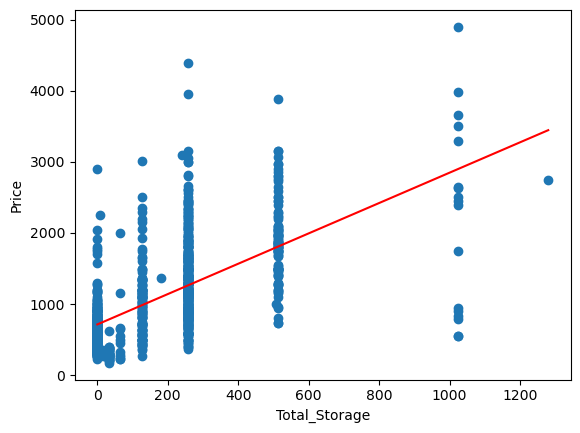

In [194]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

for var in X2.select_dtypes(include=['float64', 'int64']).columns:
    # Create a scatter plot
    plt.scatter(X2[var], Y2)

    # Fit a linear regression line
    slope, intercept, r_value, p_value, std_err = linregress(X2[var], Y2)
    x = np.linspace(X2[var].min(), X2[var].max(), 100)
    y = slope * x + intercept

    # Plot the linear regression line
    plt.plot(x, y, color='red')

    # Add labels and show the plot
    plt.xlabel(var)
    plt.ylabel('Price')
    plt.show()


## Regresion lineal

In [153]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

# R-squared score
r2 = r2_score(y_test, y_pred)
print("R-squared score: %.2f" % r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: %.2f" % mae)


Mean squared error: 130845.44
R-squared score: 0.71
Mean Absolute Error: 265.70


In [154]:
from sklearn.model_selection import KFold

# Create a k-fold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Perform k-fold cross-validation and get the mean score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X2, Y2, cv=kf, scoring='neg_mean_squared_error')
mse = -1 * scores.mean()

scores_mae = cross_val_score(model, X2, Y2, cv=kf, scoring='neg_mean_absolute_error')
mae = -1 * scores_mae.mean()

print("Mean squared error: %.2f" % mse)
print("Mean absolute error: %.2f" % mae)

Mean squared error: 119421.88
Mean absolute error: 248.63


## Regresion Polinomial

In [128]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X2)

model = LinearRegression()

model.fit(X_poly, Y2)

y_pred = model.predict(poly.fit_transform(X_test))

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

r2 = r2_score(y_test, y_pred)
print("R-squared score: %.2f" % r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: %.2f" % mae)

print("Resultados con K-folding")
# with k-folding
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_poly, Y2, cv=kf, scoring='neg_mean_squared_error')
mse = -1 * scores.mean()

scores_mae = cross_val_score(model, X_poly, Y2, cv=kf, scoring='neg_mean_absolute_error')
mae = -1 * scores_mae.mean()

print("Mean squared error: %.2f" % mse)
print("Mean absolute error: %.2f" % mae)

Mean squared error: 25039.26
R-squared score: 0.94
Mean Absolute Error: 106.05
Resultados con K-folding
Mean squared error: 295108418135605376.00
Mean absolute error: 39770960.18


## Random Forest Regression

In [196]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, criterion='absolute_error',random_state=42
                              #,max_features= 36
                              )
rf_reg.fit(X2, Y2)
#rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean squared error: %.2f" % mse)
print("Mean absolute error: %.2f" % mae)


Mean squared error: 10271.00
Mean absolute error: 69.18


In [197]:
y_t = rf_reg.predict(test)

In [198]:
test_print = pd.DataFrame({'id': test_id, 'Price_euros': y_t})
test_print

,id,Price_euros
912,824,1566.57597
913,101,341.45850
914,1157,1788.56374
915,940,1218.65396
916,853,1522.87350
...,...,...
1298,292,553.91084
1299,688,583.92638
1300,910,1226.77654
1301,54,478.32420


In [124]:
test_print.to_csv('/kaggle/working/submissionRFR6.csv',index=0)

In [76]:
"""
from sklearn.model_selection import KFold, cross_val_score

rf_reg = RandomForestRegressor(n_estimators=500, criterion='absolute_error', random_state=42)

# Create a KFold 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Folding Cross Validation
scores_mse = cross_val_score(rf_reg, X2, Y2, cv=kf, scoring='neg_mean_squared_error')
scores_mae = cross_val_score(rf_reg, X2, Y2, cv=kf, scoring='neg_mean_absolute_error')

mse = -1 * scores_mse.mean()
mae = -1 * scores_mae.mean()

print("Mean squared error: %.2f" % mse)
print("Mean absolute error: %.2f" % mae)
#192
"""

Mean squared error: 92973.82
Mean absolute error: 192.50


## Gradient Boosting

In [77]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

r2 = r2_score(y_test, y_pred)
print("R-squared score: %.2f" % r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: %.2f" % mae)


Mean squared error: 89235.58
R-squared score: 0.80
Mean Absolute Error: 208.83


In [78]:
# Create a KFold 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# K-Folding Cross Validation
scores_mse = cross_val_score(model, X2, Y2, cv=kf, scoring='neg_mean_squared_error')
scores_mae = cross_val_score(model, X2, Y2, cv=kf, scoring='neg_mean_absolute_error')

mse = -1 * scores_mse.mean()
mae = -1 * scores_mae.mean()

print("Mean squared error: %.2f" % mse)
print("Mean absolute error: %.2f" % mae)

Mean squared error: 90077.64
Mean absolute error: 202.12


## Redes Neuronales

In [79]:
"""
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(70, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dense(50, activation = 'relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.LeakyReLU(alpha=0.9),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='Nadam')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.2f" % mse)

r2 = r2_score(y_test, y_pred)
print("R-squared score: %.2f" % r2)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: %.2f" % mae)
"""
#240

6/6 [==============================] - 0s 2ms/step
Mean squared error: 140950.32
R-squared score: 0.69
Mean Absolute Error: 245.19
